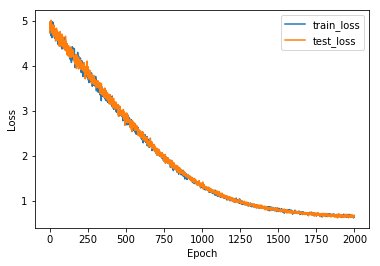

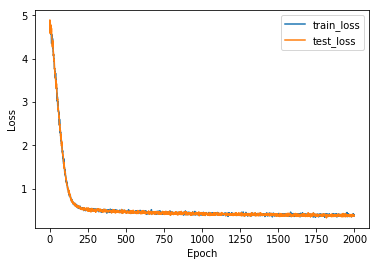

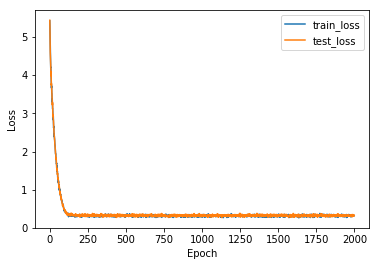

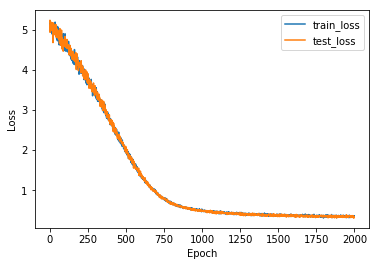

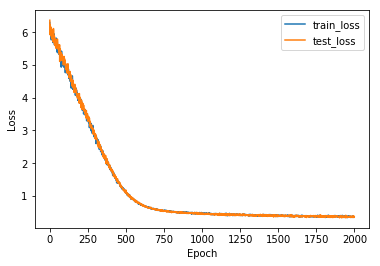

In [2]:
from sklearn import datasets, model_selection
import numpy as np
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt


def loss_function(X, y ,theta):
        y_prediction = sigmod(X.dot(theta))
        loss = -1./X.shape[0] * (y*np.log(y_prediction)+ (1-y)*np.log(1-y_prediction)).sum()
        return loss
    
def gradient(X, y, theta):
        gradient = 1./X.shape[0] * np.dot(X.transpose(), sigmod(X.dot(theta))-y)
        return gradient
    
def sigmod(z):
        return 1./(1+ np.exp(-z))
    
    
def train(X_train, y_train, theta, episode,
            learning_rate=0.01, 
            optimizer=None, 
            optimizer_params=None):
        if optimizer == None:
            grad = gradient(X_train, y_train, theta)
            theta -= learning_rate*grad
        elif optimizer == "NAG":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            momemtum = optimizer_params.setdefault('momemtum', 0.9)
            
            grad = gradient(X_train, y_train, theta+ momemtum*Velocity)
            Velocity = momemtum*Velocity - learning_rate*grad
            theta += Velocity

            optimizer_params['Velocity'] = Velocity
        elif optimizer == "RMSprop":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            decay_rate = optimizer_params.setdefault('decay_rate', 0.9)
            epsilon = optimizer_params.setdefault('epsilon', 1e-7)

            grad = gradient(X_train, y_train, theta)
            Velocity = decay_rate*Velocity + (1-decay_rate)*(grad**2)            
            theta -= learning_rate*grad/(np.sqrt(epsilon) + Velocity)
            
            optimizer_params['Velocity'] = Velocity
        elif optimizer == "Adadelta":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            update_accumulate = optimizer_params.setdefault('update_accumulate', np.zeros(theta.shape))
            decay_rate = optimizer_params.setdefault('decay_rate', 0.9)
            epsilon = optimizer_params.setdefault('epsilon', 1e-7)

            grad = gradient(X_train, y_train, theta)
            Velocity = decay_rate*Velocity + (1-decay_rate)*(grad**2)
            step_update = -(np.sqrt(update_accumulate+epsilon))*grad/(np.sqrt(Velocity+epsilon))
        
            theta +=  step_update
            update_accumulate = decay_rate*update_accumulate + (1-decay_rate)*(step_update**2)
            
            optimizer_params['update_accumulate'] = update_accumulate
            optimizer_params['Velocity'] = Velocity
        elif optimizer == "Adam":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            S = optimizer_params.setdefault('S', np.zeros(theta.shape))
            beta1 =  optimizer_params.setdefault('beta1', 0.9)
            beta2 = optimizer_params.setdefault('beta2', 0.999)
            epsilon = optimizer_params.setdefault('epsilon', 1e-8)
            
            grad = gradient(X_train, y_train, theta)
            S = beta1*S + (1-beta1)*grad
            Velocity = beta2*Velocity + (1-beta2)*(grad**2)
            
            S_t = S/(1 - (beta1**episode))
            Velocity_t = Velocity/(1- (beta2**episode))
            step_update = - learning_rate * S_t/ (np.sqrt(Velocity_t) + epsilon)
            theta += step_update

            optimizer_params['S'] = S
            optimizer_params['Velocity'] = Velocity
        return theta

    
def accuracy_of_classification(X, y, theta, threshold=0.5):
        y_prediction = sigmod(X.dot(theta))
        y_prediction[y_prediction<threshold] = 0
        y_prediction[y_prediction>=threshold] = 1
        
        #compute accuray of classification
        classification = y-y_prediction
        index = np.where(classification==0)
        accuracy = len(index[0])/classification.shape[0]
        return accuracy

def data_loader(file, n_features=None):
    if n_features==None:
        inputs,labels = datasets.load_svmlight_file(file)
    else:
        inputs,labels = datasets.load_svmlight_file(file,n_features=n_features)
    one = np.ones((inputs.shape[0],1))
    inputs = hstack( [inputs, csr_matrix(one)] ).toarray()
    labels = np.array(labels).reshape(inputs.shape[0],1)
    labels[labels==-1] = 0
    return inputs, labels

def get_batch(X, y ,mini_batch):
    index = np.random.randint(0,X.shape[0], size=mini_batch, dtype=int)
    return X[index,:], y[index]

def plot_loss(train_loss, test_loss):
    
    figure1 = plt.figure(1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(train_loss, label="train_loss")
    plt.plot(test_loss, label="test_loss")
    plt.legend(loc='upper right')

    plt.show()

def main(trian_file, test_file, 
        learning_rate=0.01, 
        threshold=0.5, 
        mini_batch=64, 
        epoch=1000,     
        optimizer=None,
        optimizer_params=None):
    X_train, y_train = data_loader(trian_file)
    X_test, y_test = data_loader(test_file, X_train.shape[1]-1)
    theta = np.random.random((X_train.shape[1], 1))
    train_loss = []
    test_loss = []
    test_accuracy = []
    for episode in range(1,epoch):
        X_train_batch, y_train_batch = get_batch(X_train, y_train, mini_batch)
        theta = train(X_train_batch, y_train_batch, theta, episode=episode, learning_rate=learning_rate, optimizer=optimizer, optimizer_params=optimizer_params)
        
        loss = loss_function(X_train_batch, y_train_batch, theta)
        train_loss.append(loss)
        
        X_test_batch, y_test_batch = get_batch(X_test, y_test, mini_batch)
        loss = loss_function(X_test_batch, y_test_batch,theta)
        test_loss.append(loss)
        accuracy = accuracy_of_classification(X_test_batch, y_test_batch, theta, threshold)
        test_accuracy.append(accuracy)
    plot_loss(train_loss, test_loss)

if __name__ == "__main__":
    train_params = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.001,
        'epoch': 2000,
        'threshold': 0.5,
        'mini_batch': 1024,
        'optimizer': None
    }
    train_params_NAG = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.001,
        'epoch': 2000,
        'threshold': 0.5,
        'mini_batch': 1024,
        'optimizer': 'NAG'
    }
    train_params_RMSprop = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.001,
        'epoch': 2000,
        'threshold': 0.5,
        'mini_batch': 1024,
        'optimizer': 'RMSprop'
    }
    train_params_Adadelta = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.001,
        'epoch': 2000,
        'threshold': 0.5,
        'mini_batch': 1024,
        'optimizer': 'Adadelta'
    }
    train_params_Adam = {
        'trian_file': 'a9a.txt',
        'test_file': 'a9a.t',
        'learning_rate': 0.001,
        'epoch': 2000,
        'threshold': 0.5,
        'mini_batch': 1024,
        'optimizer': 'Adam'
    }
    optimizer_params={
        'momemtum': 0.9,
        'decay_rate': 0.9,
        'epsilon':1e-8
    }
    main(**train_params, optimizer_params=optimizer_params)
    main(**train_params_NAG, optimizer_params=optimizer_params)
    main(**train_params_RMSprop, optimizer_params=optimizer_params)
    main(**train_params_Adadelta, optimizer_params=optimizer_params)
    main(**train_params_Adam, optimizer_params=optimizer_params)